In [1]:
# import libraries
from matipo import SEQUENCE_DIR, GLOBALS_DIR
from matipo.sequence import Sequence
from matipo.util.autophase import autophase
from matipo.util.decimation import decimate
from matipo.util.fft import fft_reconstruction, get_freq_spectrum
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import ipyvolume as ipv

# progress_handler for Sequence.run() that simply prints the progress
def print_progress(p, l):
    if p%(l//4)==0: # only print 4 times per run
        print(p, '/', l)

# find frequency utility: runs FID, calculates and returns centre frequency
FIDseq = Sequence(SEQUENCE_DIR+'FID.py')
FIDseq.loadpar(GLOBALS_DIR+'frequency.yaml')
async def findfreq():
    """ Runs FID and returns centre frequency calculated by integrating the spectrum"""
    FIDseq.loadpar(GLOBALS_DIR+'hardpulse_90.yaml')
    FIDseq.loadpar(GLOBALS_DIR+'shims.yaml')
    FIDseq.setpar(t_dw=64e-6, n_samples=1000, n_scans=1)
    await FIDseq.run()
    _, fft = get_freq_spectrum(FIDseq.data, FIDseq.par.t_dw)
    fft_abs = np.abs(fft)
    fft_abs_sum = np.cumsum(fft_abs)
    # find index corresponding to half the integral of fft_abs, rounded down
    f_index = np.searchsorted(fft_abs_sum, fft_abs_sum[-1]/2.0)
    # interpolate the index to get the true halfway point
    f_index += (fft_abs_sum[-1]/2.0 - fft_abs_sum[f_index-1])/(fft_abs_sum[f_index] - fft_abs_sum[f_index-1]) - 1
    # calculate the frequency corresponding to the index
    freq = FIDseq.par.f + (1/FIDseq.par.t_dw)*(f_index/FIDseq.par.n_samples-0.5)
    FIDseq.setpar(f=freq) # update frequency parameter for next run
    return freq

# based on https://stackoverflow.com/a/44164075
def sphere_points(num_pts):
    """ Generates N points on the unit sphere that are fairly evenly spaced """
    indices = np.arange(0, num_pts, dtype=float) + 0.5
    phi = np.arccos(1 - 2*indices/num_pts)
    theta = np.pi * (1 + 5**0.5) * indices
    x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)
    return np.array([x, y, z]).T # format into array of x,y,z arrays

## Slice DTI
Measure the diffusion tensor in a slice using a Diffusion Weighted Spin Echo sequence.

Pulse sequence `SE-DTI.py`:

`90 pulse | delay | diffusion gradient | 180 pulse | diffusion gradient | phase gradient | read gradient + acquisition | spoiler gradient`

Repeating for each phase gradient step.

The whole sequence is rerun for each phase gradient step. The `findfreq()` utility is run before each imaging sequence to ensure that there is no offset along the frequency encode dimension due to NMR frequency drift.

The diffusion tensor can be determined from a number of diffusion weighted images with diffusion gradients in different directions and with different magnitudes. Ideally the directions are evenly dispersed on a sphere, the `sphere_points()` function defined above generates approximately evenly dispersed points.

The gradient vectors will be saved to `gradient_table.txt` in the save directory, and the data for each step saved as `<gradient index>.npy` (e.g. `0.npy` for the first diffusion gradient value).

In [2]:
# set save directory and base file name
SAVE_DIR = '/home/data/DTI'
SAVE_NAME = 'spool_10dir'

# make the save directory if it doesn't exist
Path(SAVE_DIR, SAVE_NAME).mkdir(parents=True, exist_ok=True)

#### Generate Diffusion Gradient Table

In [3]:
N_mag = 2 # number of magnitudes per direction
N_directions = 10 # number of directions
diffgrad_mag_max = 0.5 # uncalibrated, just proportion of maximum possible amplitude
diffgrad_directions = sphere_points(N_directions)
# generate gradient magnitudes in such a way that the b-values will be linearly increasing
diffgrad_mag = diffgrad_mag_max*np.sqrt(np.linspace(0, 1, N_mag+1)[1:]) # Don't include 0 gradient magnitude here
# order gradients to run different magnitudes in the same direction consecutively
diffgrad = np.reshape(diffgrad_directions[:,np.newaxis,:]*diffgrad_mag[np.newaxis,:,np.newaxis], (N_directions*N_mag, 3))
# prepend [0,0,0] gradient
diffgrad = np.vstack([[0,0,0], diffgrad])

# visualise gradient vectors
fig = ipv.figure()
ipv.xyzlim(diffgrad_mag_max)
ipv.scatter(diffgrad[:,0], diffgrad[:,1], diffgrad[:,2], size=3, marker="sphere")
ipv.show()

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

#### Run Sequence for each Diffusion Gradient Vector

In [4]:
# load local pulse sequence
seq = Sequence('SE-DTI.py')

# load relevant global variables
# seq.loadpar(GLOBALS_DIR+'hardpulse_90.yaml')
seq.loadpar(GLOBALS_DIR+'hardpulse_180.yaml')
seq.loadpar(GLOBALS_DIR+'frequency.yaml')
seq.loadpar(GLOBALS_DIR+'shims.yaml')

seq.loadpar(GLOBALS_DIR+'softpulse_90_8.0mm.yaml')
g_slice = seq.par.g_slice*np.array([0, 0, 1.0]) # slice through Z axis

DECIMATION = 4

# set parameters for a 24x24 X/Y 2D projection SE image
seq.setpar(
    g_slice = g_slice,
    
    # duration of phase pulse, not including ramping
    t_phase=160e-6,
    
    # phase encode Y axis
    n_phase_1=24,
    g_phase_1=(0, -0.6, 0),
    
    # frequency encode X axis
    g_phase_read=(-0.6, 0, 0),
    t_dw=10e-6,
    n_samples=DECIMATION*24,
    g_read=(0.2, 0, 0),
    
    g_spoil=(0.8, 0, 0), # same direction as read gradient
    t_spoil=2e-3,
    
    t_diff=10e-3,
    g_diff=(0,0,0),
    
    t_end=0.1,
    n_scans=4
)

# print out the parameter set for reference
print(seq.par)

# not perfectly accurate, but close enough
# (doesn't account full sequence time, only repetition delay)
time_est_s = len(diffgrad)*(seq.par.n_scans*seq.par.n_phase_1*seq.par.n_phase_2*seq.par.t_end)
print('total time est. (mins):', time_est_s/60)

# save gradient table
np.savetxt(f'{SAVE_DIR}/{SAVE_NAME}/gradient_table.txt', diffgrad)
for i, G in enumerate(diffgrad):
    print(f'{i+1}/{len(diffgrad)} Diff Grad: {np.array2string(G, precision=2, suppress_small=True)}')
    freq = await findfreq()
    seq.setpar(f=freq, g_diff=G)
    await seq.run()
    y_ = decimate(np.reshape(seq.data, (seq.par.n_phase_1, seq.par.n_samples)), DECIMATION, axis=1)
    # save data and parameters
    np.save(f'{SAVE_DIR}/{SAVE_NAME}/{i}', y_)
    seq.savepar(f'{SAVE_DIR}/{SAVE_NAME}/{i}.yaml')

# compress data directory to archive
import shutil
shutil.make_archive(f'{SAVE_DIR}/{SAVE_NAME}', 'zip', f'{SAVE_DIR}/{SAVE_NAME}')

ParameterSet(n_scans=4, f=14596318.24424671, a_90=0.1849427448991698, t_90=0.00015999999999999999, bw_90=32000.0, g_slice=array([0. , 0. , 0.4]), a_180=0.5752412353661719, t_180=3.2e-05, t_dw=1e-05, n_samples=96, g_read=array([0.2, 0. , 0. ]), t_phase=0.00016, g_phase_read=array([-0.6,  0. ,  0. ]), n_phase_1=24, g_phase_1=array([ 0. , -0.6,  0. ]), n_phase_2=1, g_phase_2=array([0., 0., 0.]), t_diff=0.01, g_diff=array([0., 0., 0.]), t_spoil=0.002, g_spoil=array([0.8, 0. , 0. ]), t_grad_ramp=0.0001, n_grad_ramp=10, t_end=0.1, shim_x=-0.10011834928925065, shim_y=0.1216704879609545, shim_z=0.6090207052113977, shim_z2=-0.10489898522204966, shim_zx=-0.0025577384649718873, shim_zy=0.13488417594724078, shim_xy=0.021255000422356618, shim_x2y2=-0.05114920801990194)
total time est. (mins): 3.3600000000000003
1/21 Diff Grad: [0. 0. 0.]
2/21 Diff Grad: [ 0.06 -0.14  0.32]
3/21 Diff Grad: [ 0.08 -0.2   0.45]
4/21 Diff Grad: [-0.23  0.11  0.25]
5/21 Diff Grad: [-0.32  0.16  0.35]
6/21 Diff Grad: [0.

'/home/data/DTI/spool_10dir.zip'

#### Load saved data

In [5]:
ys = []
for i, G in enumerate(diffgrad):
    ys.append(np.load(f'{SAVE_DIR}/{SAVE_NAME}/{i}.npy'))

#### Fourier Reconstruction & Masking

In [6]:
upscale=2
blur=2
ims = []
for i, G in enumerate(diffgrad):
    ims.append(np.abs(fft_reconstruction(ys[i], upscale_factor=upscale, gaussian_blur=blur)))

cmap = 'gray'
vmin = np.min(ims[0])
vmax = np.max(ims[0])

mask = np.copy(ims[0])
thresh = 0.25*np.max(mask) # adjust to alter the threshold, quarter of maximum is a good starting point
mask[mask > thresh] = 1
mask[mask <= thresh] = np.nan

#### Diffusion Weighted Images

/usr/local/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


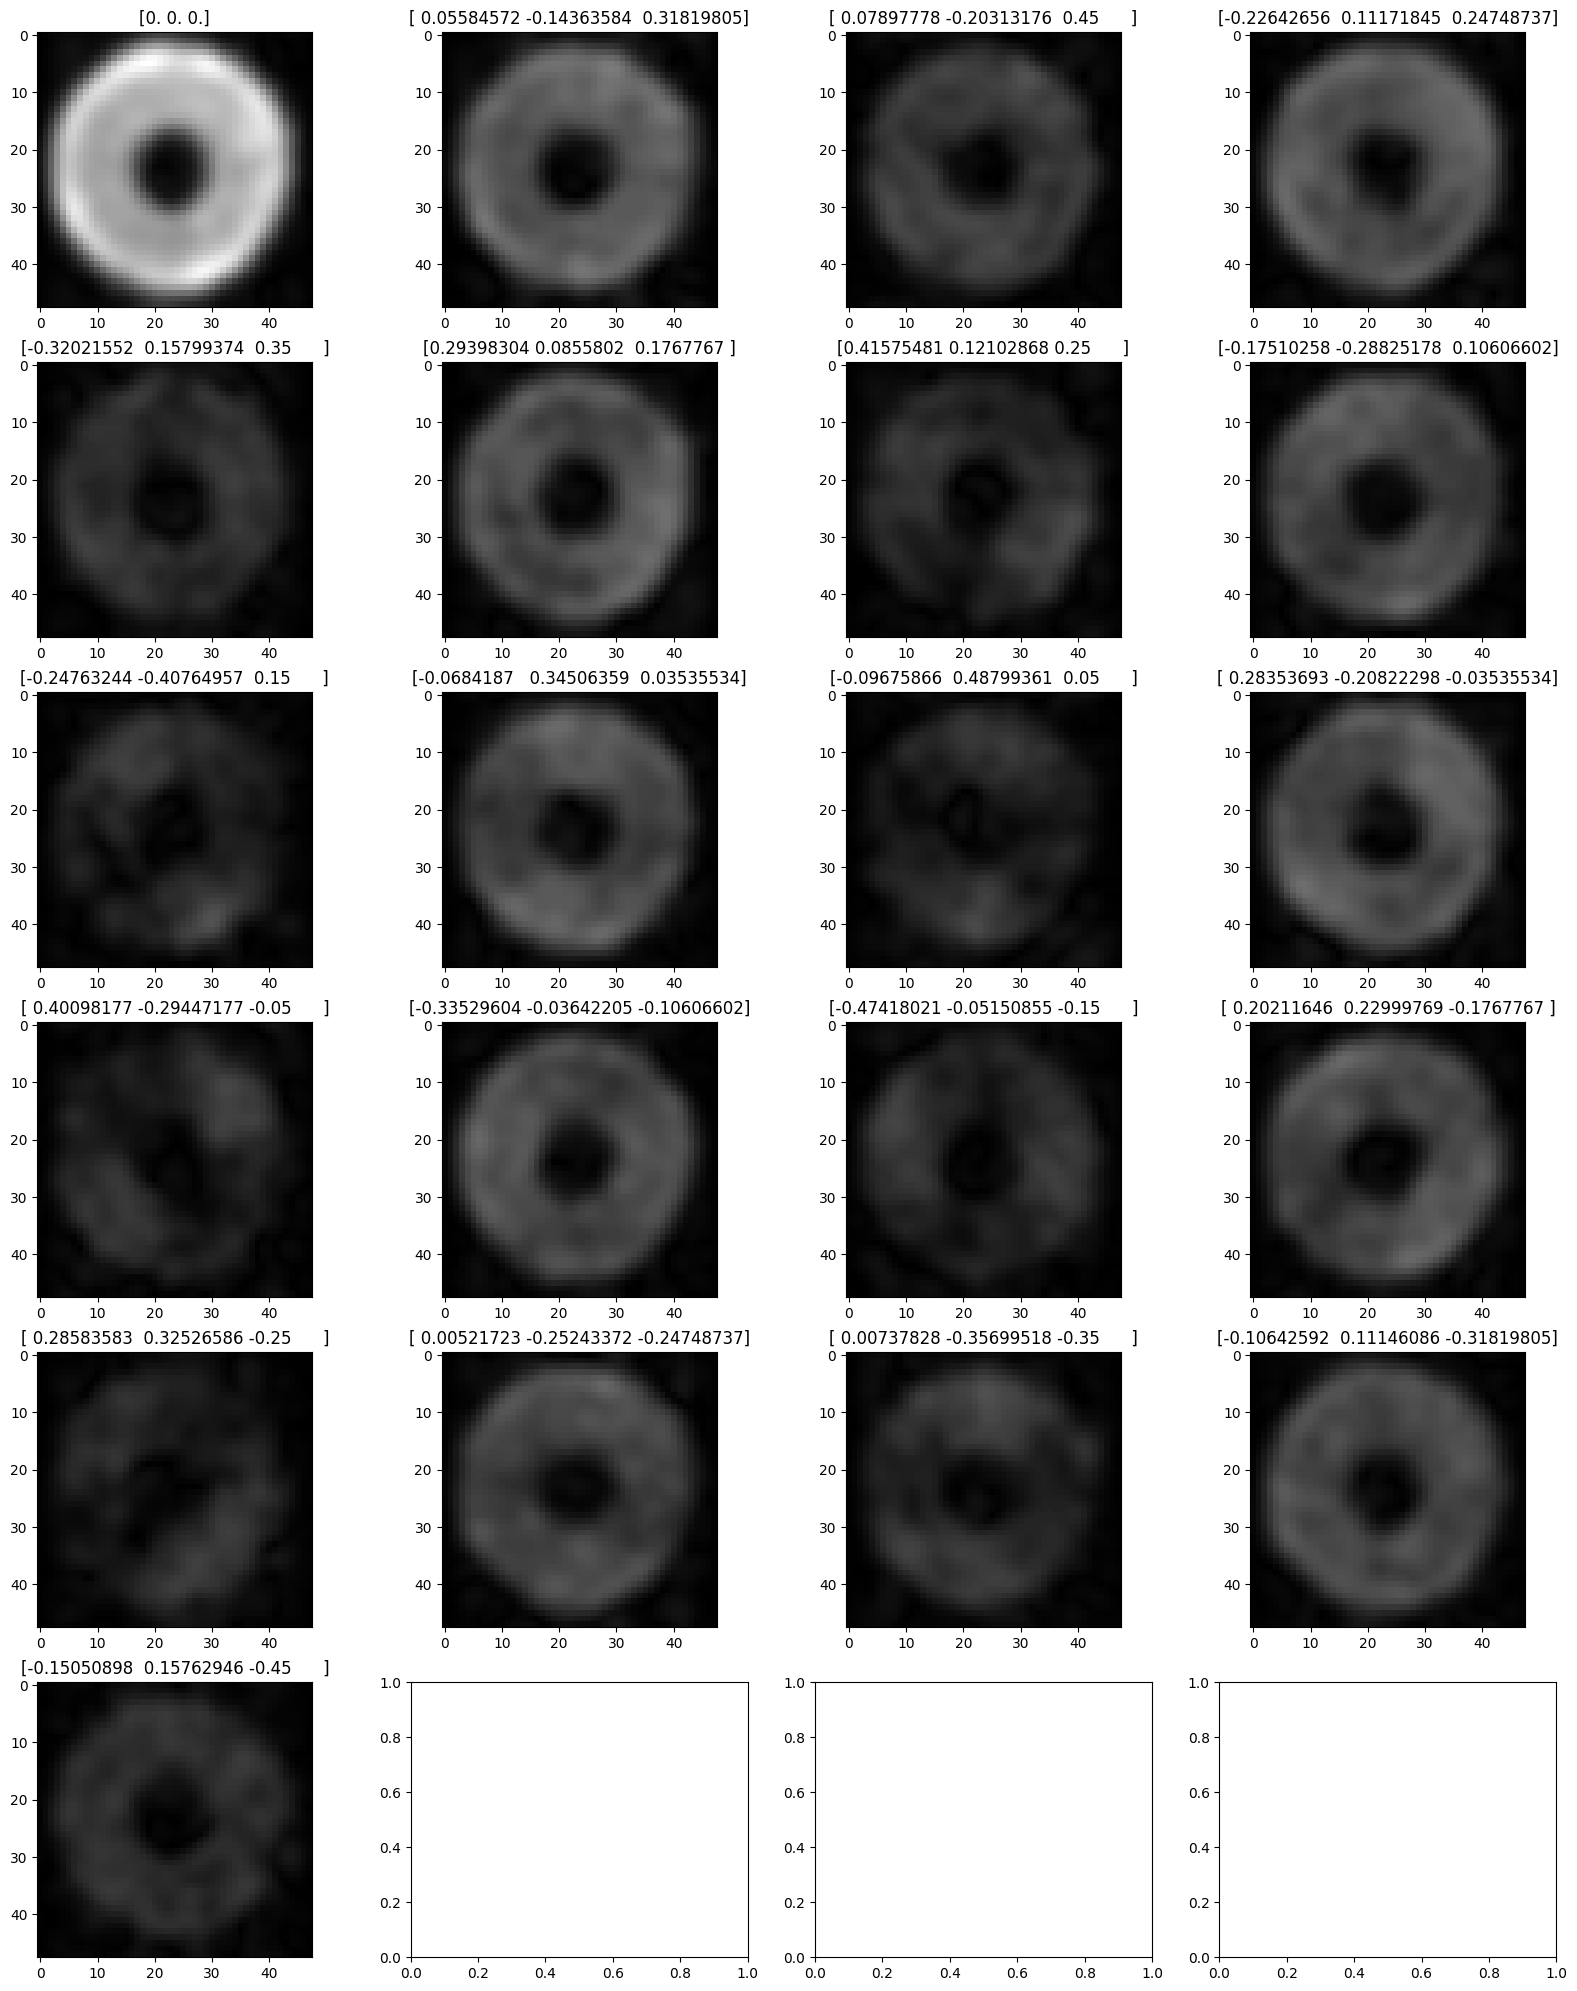

In [7]:
fig, axes = plt.subplots(nrows=(len(diffgrad)//4+1), ncols=4, figsize=(20,len(diffgrad)+4))
for i, G in enumerate(diffgrad):
    axes[i//4, i%4].imshow(ims[i], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[i//4, i%4].set_title(G)
plt.show()

#### ADC Maps

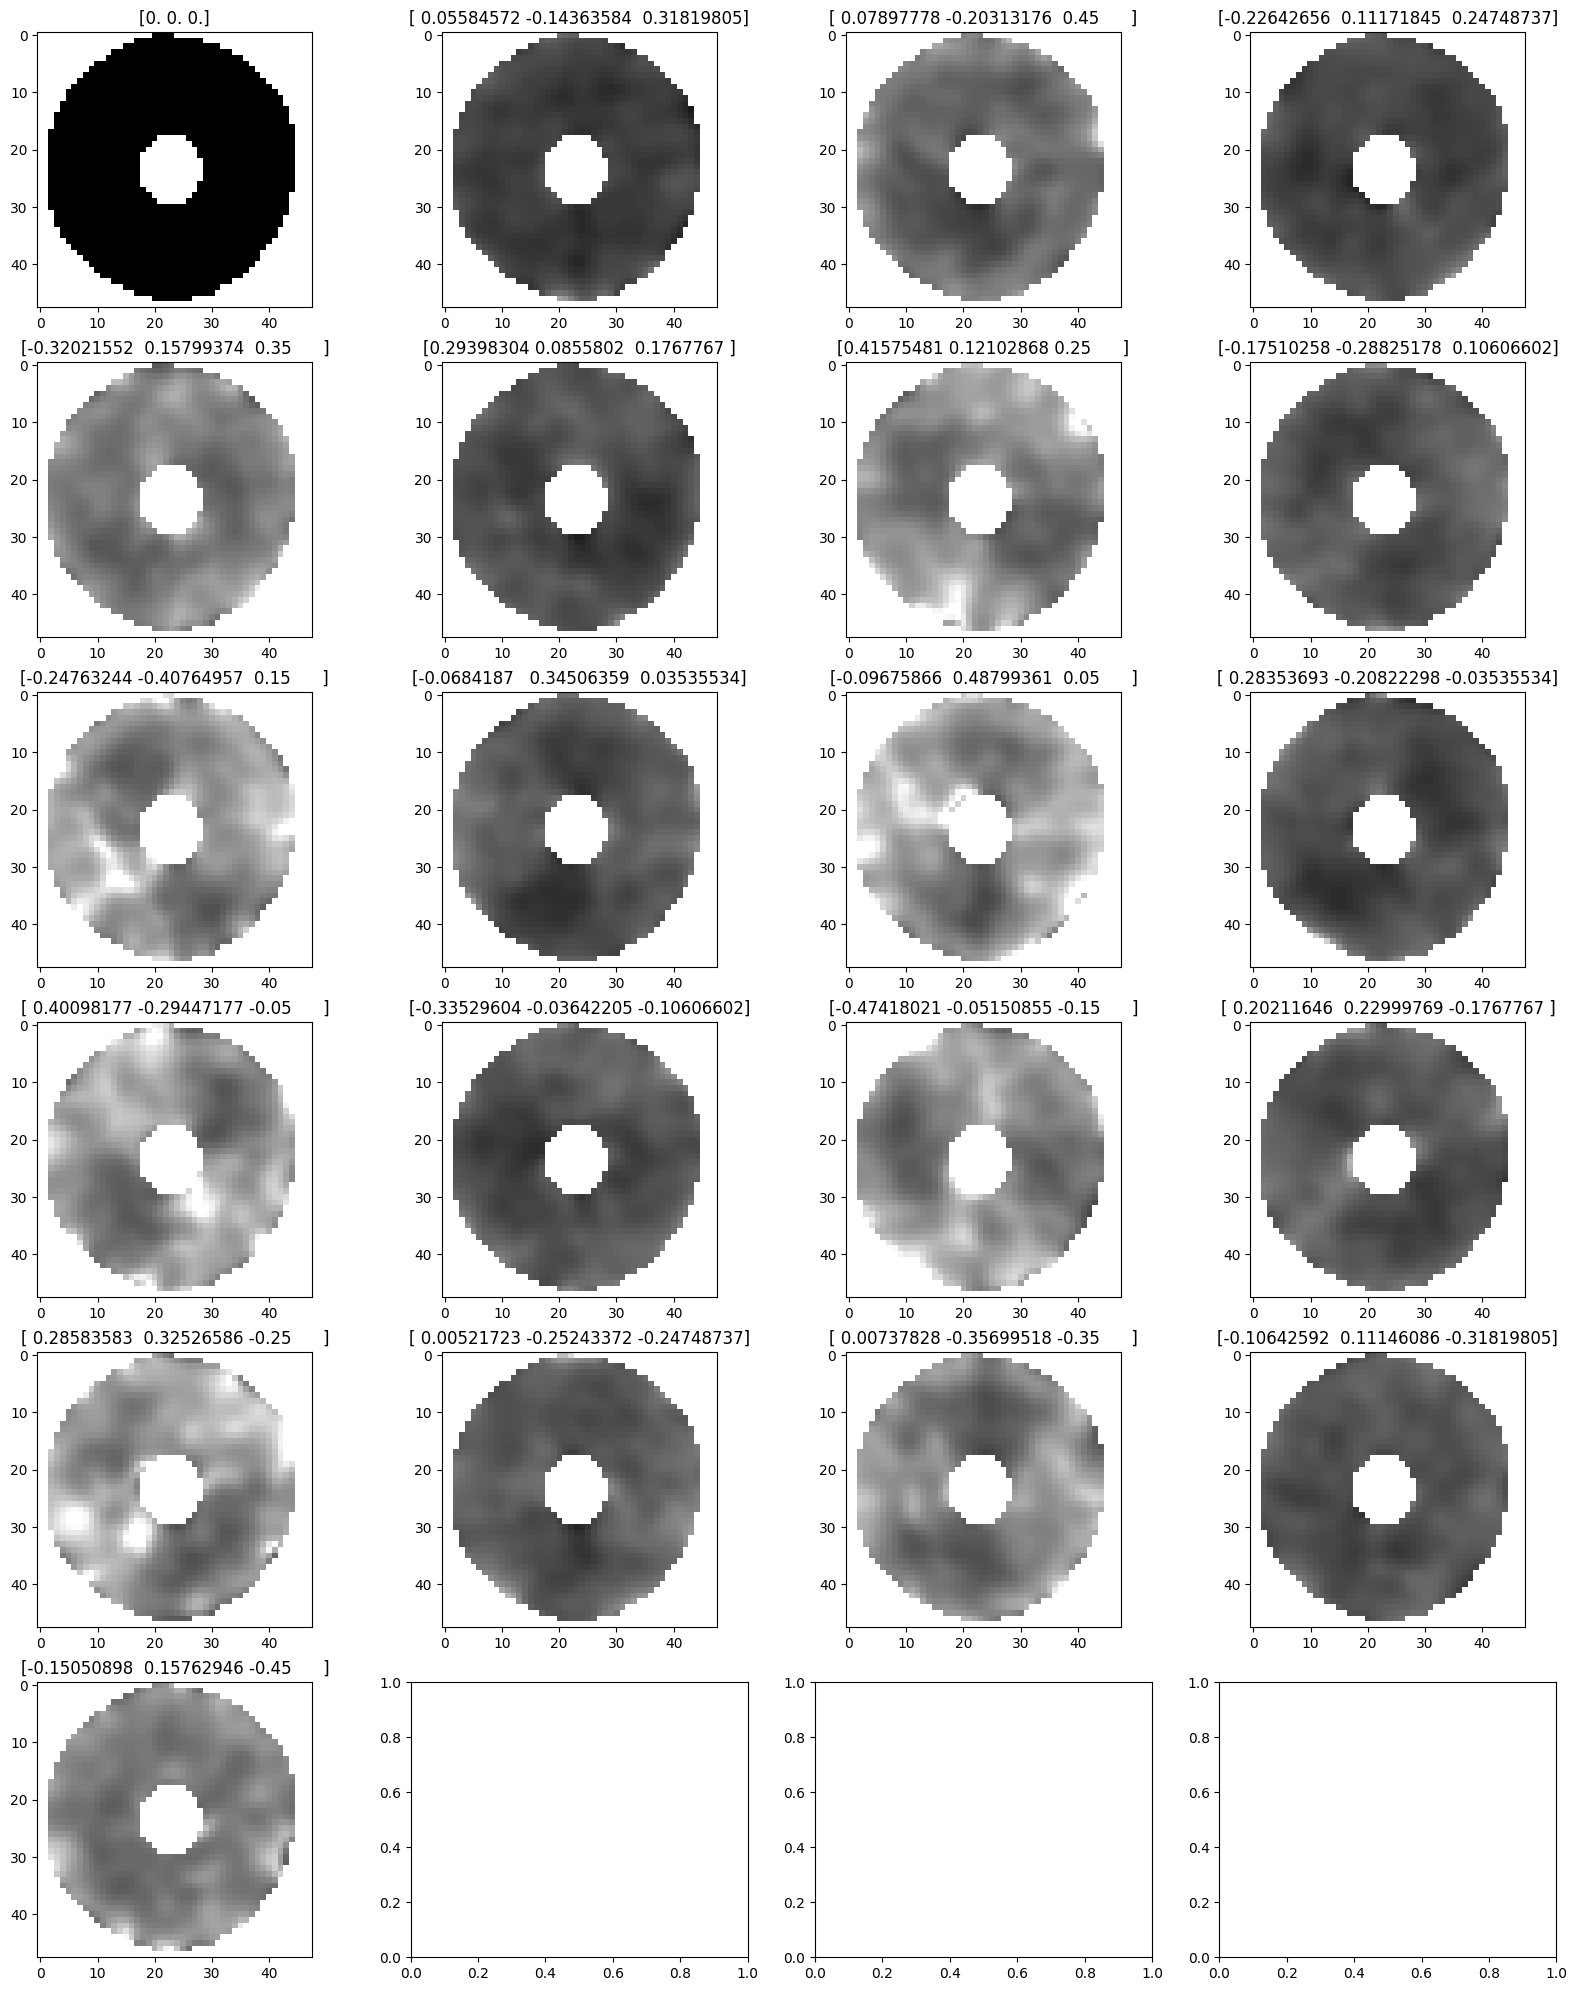

In [8]:
fig, axes = plt.subplots(nrows=(len(diffgrad)//4+1), ncols=4, figsize=(20,len(diffgrad)+4))
for i,G in enumerate(diffgrad):
    axes[i//4, i%4].imshow(
        mask*-np.log(ims[i]/ims[0]), # calculate ADC and apply mask
        cmap=cmap,
        vmin=0, # fixed vmin
        vmax=3) # fixed vmax so that plots are comparable
    axes[i//4, i%4].set_title(G) 
plt.show()